# How different weather conditions induce forest fires in Algeria

# Introduction

Climate change is causing changes in weather conditions that have the potential of inducing forest fires around the world. Located on the Mediterranean coast, Algeria houses several endangered species, like the prickly juniper. However, because Algeria's hot, dry climate increases the rate of evaporation, plants are drier than usual, and, consequently, increase the occurrence of forest fires. Thus, it is important to combat this environmental issue to prevent further decimation and degradation of Algerian forests. 

To start our analysis, we examined the dataset from the Center for Machine Learning and Intelligent Systems of the University of California in Irvine. This center mainly focuses on research in the field of machine learning and intelligent systems and aims at developing algorithms to solve real-world issues in the 21st century. The specific dataset used in our analyses is called the Algerian forest Fires dataset which contains data on two regions which are Bejaia (Northeast of Algeria) and Sidi Bel-abbes (Northwest of Algeria). The dataset contains 122 observations for each region from June 2012 to September 2012. Being a coastal city, Bejaia is more representative of the Mediterranean climate of Algeria and is better suited for our analysis which aims at predicting the occurence of forest fires from climate change in Algeria.

By focusing on the Bejaia region from the Algerian Forest Fires dataset, we chose relative humidity, wind speed, rain, and temperature as our predictors which have numerical data and represent different factors of climate change which will help in predicting the occurrence of forest fires in Bejaia on a specific day. 

# Methods and Results

## **NEW**
- describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
- your report should include code which:
     - loads data from the original source on the web 
     - wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
     - performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
     - creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
     - performs the data analysis
     - creates a visualization of the analysis 
     - note: all tables and figure should have a figure/table number and a legend


#### **From methods section in proposal**

- We will be using the K-nearest neighbour classification system, with predictors: relative humidity, wind speed, rain, and temperature, to classify new observations as "fire" or "not fire". 

    - First, we split the data set into a training set and a testing set. Then, the training set is further split into a training set and a validation set so that we can tune our model and perform a 5-fold cross-validation to choose a K-value that gives the most accurate predictions. 

    - Additionally, we will standardize the data, by scaling and centering the data so the average will be 0 and the standard deviation will be 1, to ensure all variables are on a comparable scale to contribute equally in the calculation of the distance between the points. 

    - In general, for each predictor we:
        - calculate the Euclidean distance between the new observation and each observation in the training set, 
        - place the distances in ascending order, 
        - classify the new observation to a class 


- Results will be visualized with a 4x4 group of scatterplots (and their respective distributions), where points are coloured by classes, and, therefore, will show the relationships between each variable.


In [1]:
# Loading packages
library(dplyr)
library(repr)
library(tidyverse)
library(tidymodels)
library(GGally)
library(cowplot)

Warning message:
“package ‘dplyr’ was built under R version 4.0.2”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ stringr 1.4.0
✔ tidyr   1.1.2     ✔ forcats 0.5.0
✔ readr   1.3.1     

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ b

## Exploratory Data Analysis

In [2]:
# Reading and tidying data from the web

# read .csv file
algerian_fire <- read.csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv", skip = 1)

# select the Bajaia region data and set up the right labels
bejaia_fire_0 <- algerian_fire[c(1:122), ]
bejaia_fire <- bejaia_fire_0 %>% 
                 select(day, month, year, Classes, Temperature, RH, Ws, Rain) %>%
                 mutate(Temperature = as.numeric(Temperature)) %>%
                 mutate(RH = as.numeric(RH)) %>%
                 mutate(Ws = as.numeric(Ws)) %>%
                 mutate(Rain = as.numeric(Rain)) 

# combine three columns and set it as date
bejaia_fire$date <- as.Date(with(bejaia_fire, paste(year, month, day, sep="-")), "%Y-%m-%d") 

# tidy the whole dataset
bejaia_fire_tidy <- bejaia_fire %>% 
                    select(date, Classes,Temperature, RH, Ws, Rain)
# bejaia_fire_tidy

The columns in the dataset we work with are: the date, the class: fire or not fire, the temperature in degrees Celsius, relative humidity (RH) in percentage, wind speed (Ws) in kilometers per hour (km/h), and rain in millimeters (mm).

In [3]:
# Creating the training dataset
set.seed(80)

# remove space before and after the string
bejaia_fire_tidy$Classes <- trimws(bejaia_fire_tidy$Classes)

# set the label back to factor
bejaia_fire_tidy <- bejaia_fire_tidy %>% 
                    mutate(Classes = as.factor(Classes)) 

# split and get training and testing dataset
bejaia_split <- initial_split(bejaia_fire_tidy, prop = 0.75, strata = Classes)
bejaia_train <- training(bejaia_split)
bejaia_test <- testing(bejaia_split)

In [4]:
# Create a table for the number of observations for each class

bejaia_table <- bejaia_train %>%
                group_by(Classes)%>%
                summarize(n = n())

'Table 1: Number of Observations for Each Class'
bejaia_table

`summarise()` ungrouping output (override with `.groups` argument)



[1] "Table 1: Number of Observations for Each Class"

Classes,n
<fct>,<int>
fire,45
not fire,48


In [5]:
# Preparing the training data for visualization

# preprocess and standardize data by centering and scaling
bejaia_recipe <- recipe(Classes ~ Temperature + RH + Rain, data = bejaia_train) %>% 
                 step_center(all_predictors()) %>%
                 step_scale(all_predictors())

# apply trained data recipe
bejaia_scaled <- bejaia_recipe %>%  
                 prep() %>%
                 bake(bejaia_train)

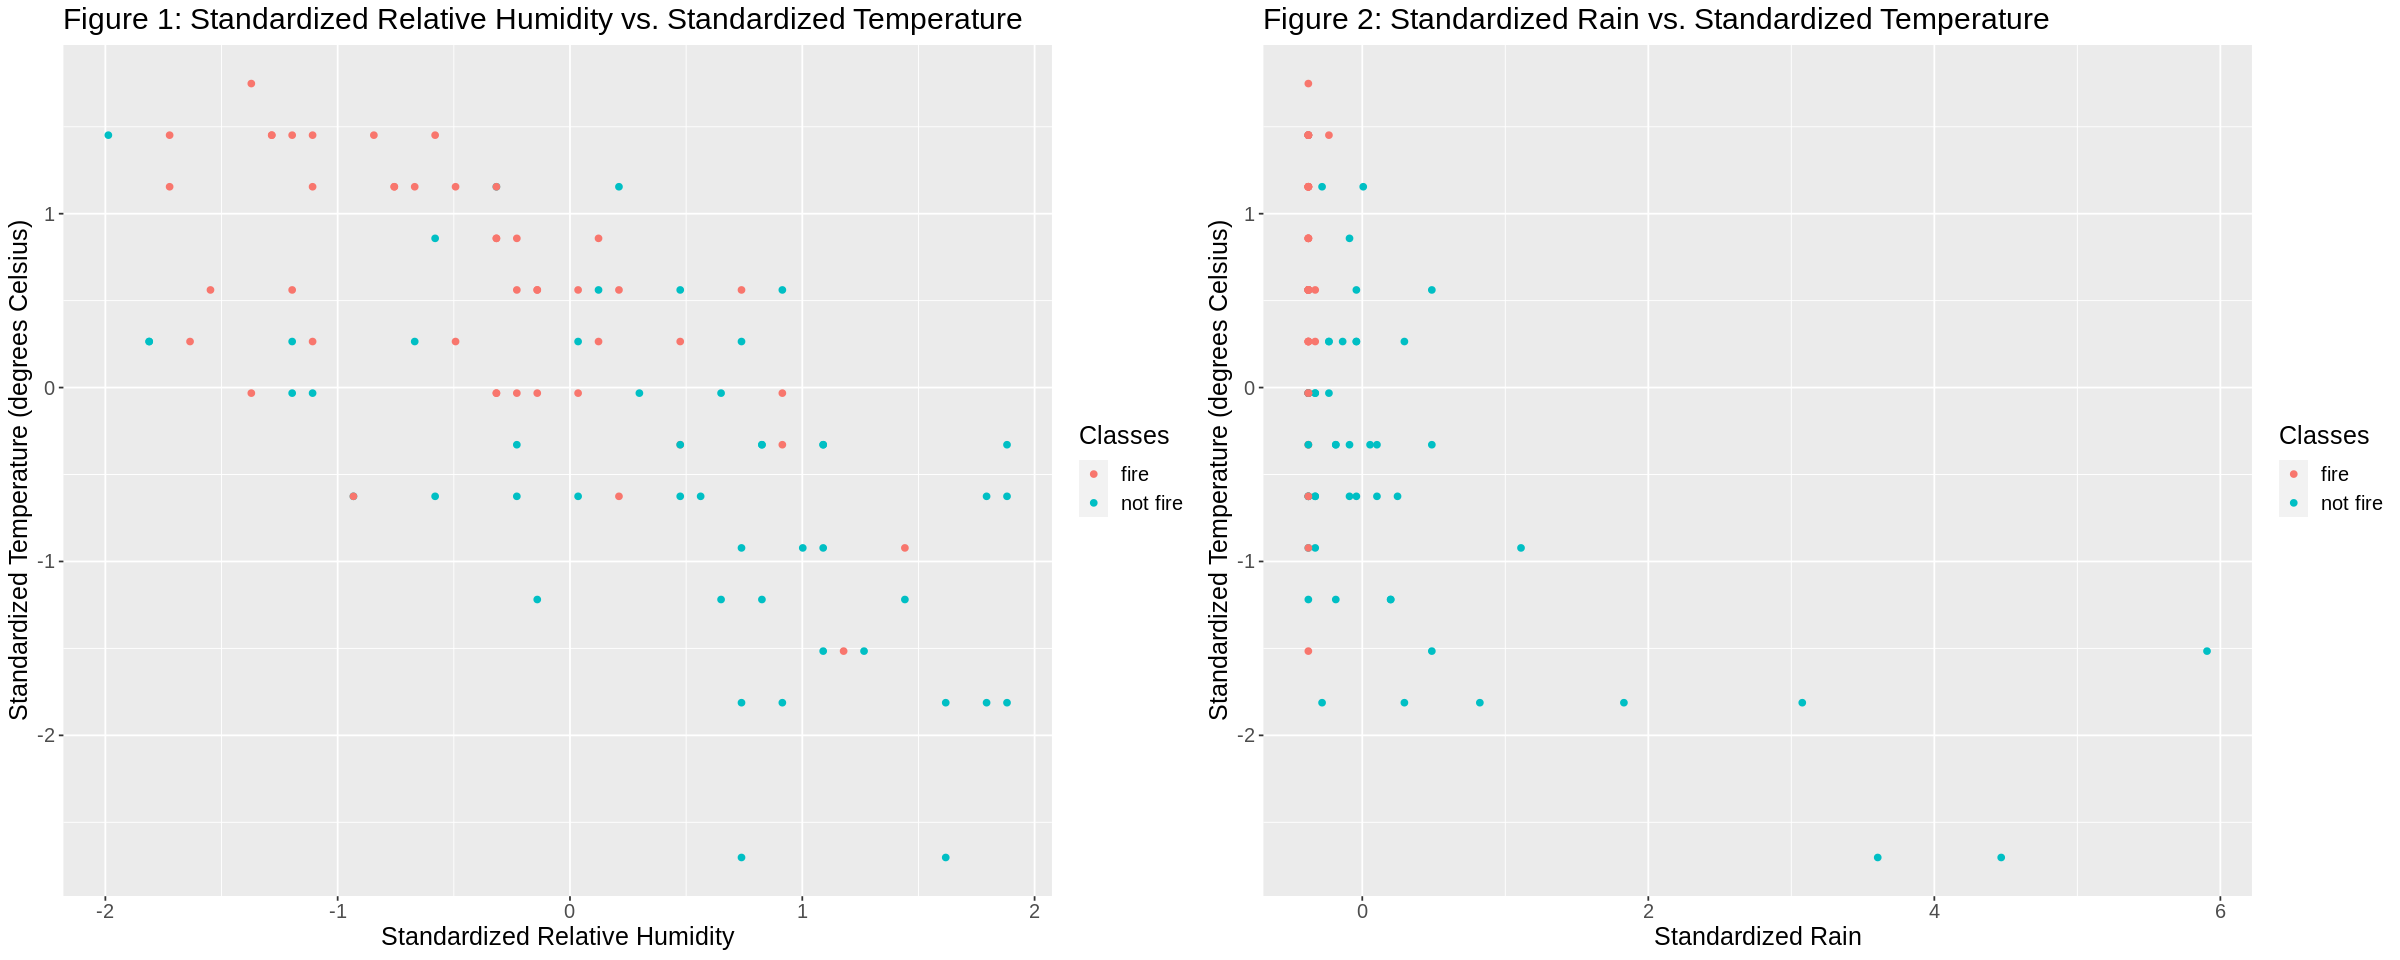

In [6]:
# The exploratory visualization 

options(repr.plot.width = 20, repr.plot.height = 8)

# Standardized Relative Humidity vs. Temperature plot
b_RH_plot <- bejaia_scaled %>% 
             ggplot(aes(x = RH, y = Temperature, color = Classes)) + 
             geom_point() + 
             ggtitle("Figure 1: Standardized Relative Humidity vs. Standardized Temperature") +
             labs(x = "Standardized Relative Humidity", y = "Standardized Temperature (degrees Celsius)", colour = "Classes")+
             theme(text = element_text(size = 15))

# Standardized Rain vs. Temperature plot
b_Ws_plot <- bejaia_scaled %>% 
             ggplot(aes(x = Rain, y = Temperature, color = Classes)) + 
             geom_point() + 
             ggtitle("Figure 2: Standardized Rain vs. Standardized Temperature") +
             labs(x = "Standardized Rain", y = "Standardized Temperature (degrees Celsius)", colour = "Classes") +
             theme(text = element_text(size = 15))

plot_grid(b_RH_plot, b_Ws_plot)
# b_RH_plot

In Figure 1, we can see that a large number of red data points, indicating that a forest fire occurred, with an increase in temperature and a decrease in the amount of relative humidity. Namely, when the temperature is above 0.5 degrees celsius and when the standardized relative humidity is below 1. Hence, temperature and relative humidity are good predictors to predict the occurence of forest fires.

In Figure 2, we can see a larger number of red data points indicating that forest fires are more likely to occur when temperature increases and when the amount of rainfall is lower. Hence, temperature and rain are good predictors to predict the occurence of forest fires.

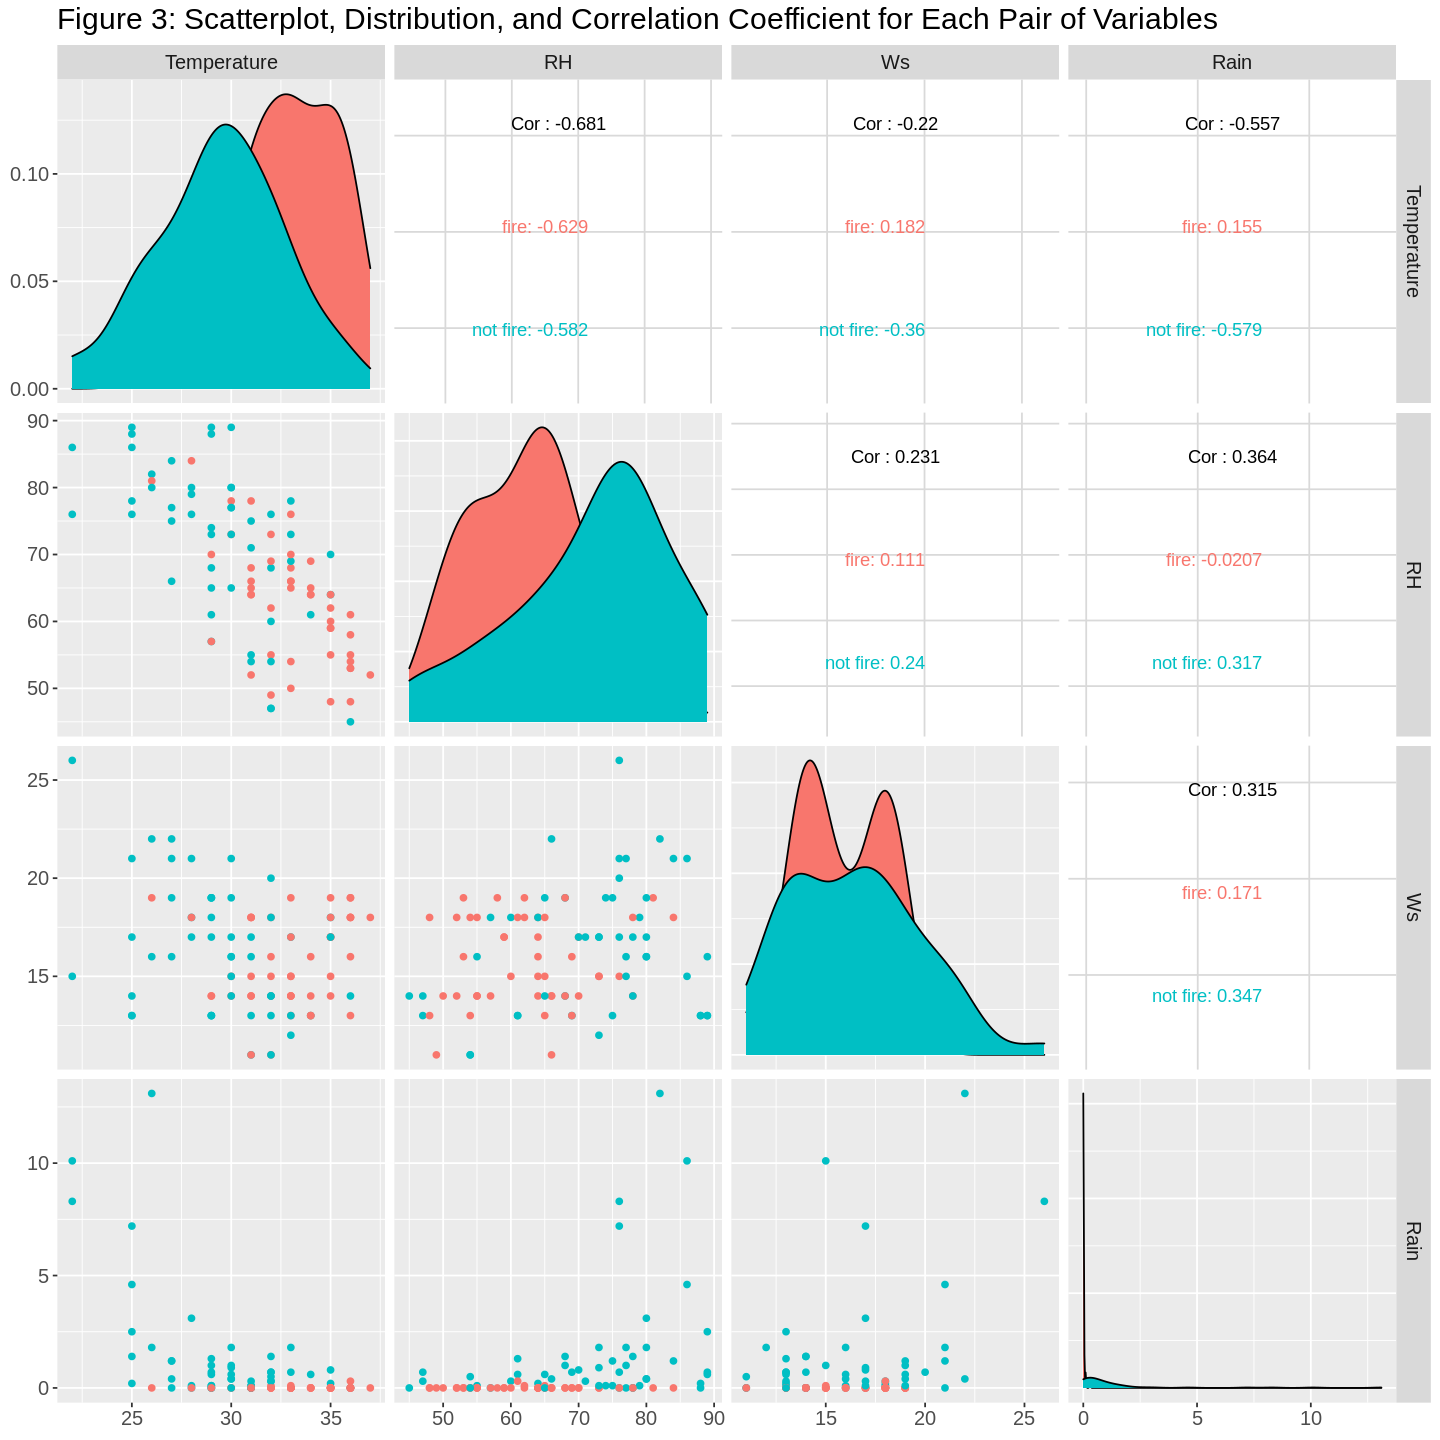

In [7]:
# The final exploratory visualization

options(repr.plot.width = 12, repr.plot.height = 12)

pairs_bejaia <- bejaia_train %>%
                select(Temperature, RH, Ws, Rain) %>%
                ggpairs(ggplot2::aes(colour = bejaia_train$Classes)) +
                ggtitle("Figure 3: Scatterplot, Distribution, and Correlation Coefficient for Each Pair of Variables") +
                theme(text = element_text(size = 15))
pairs_bejaia

From the grid, we can observe that temperature and relative humidity have a strong, linear, negative relation such that as rain decreases, temperature increases and more forest fires occur. Also, from the last 3 scatterplots on the last row, we can see that there are no fires when there is rain. 

Therefore, in our analysis, we will use temperature, relative humidity, and rain as our predictors as they show that they are the best predictors. And we exclude wind speed because its distribution plot does not show much separation, whereas temperature and relative humidity do. 

# Data Analysis

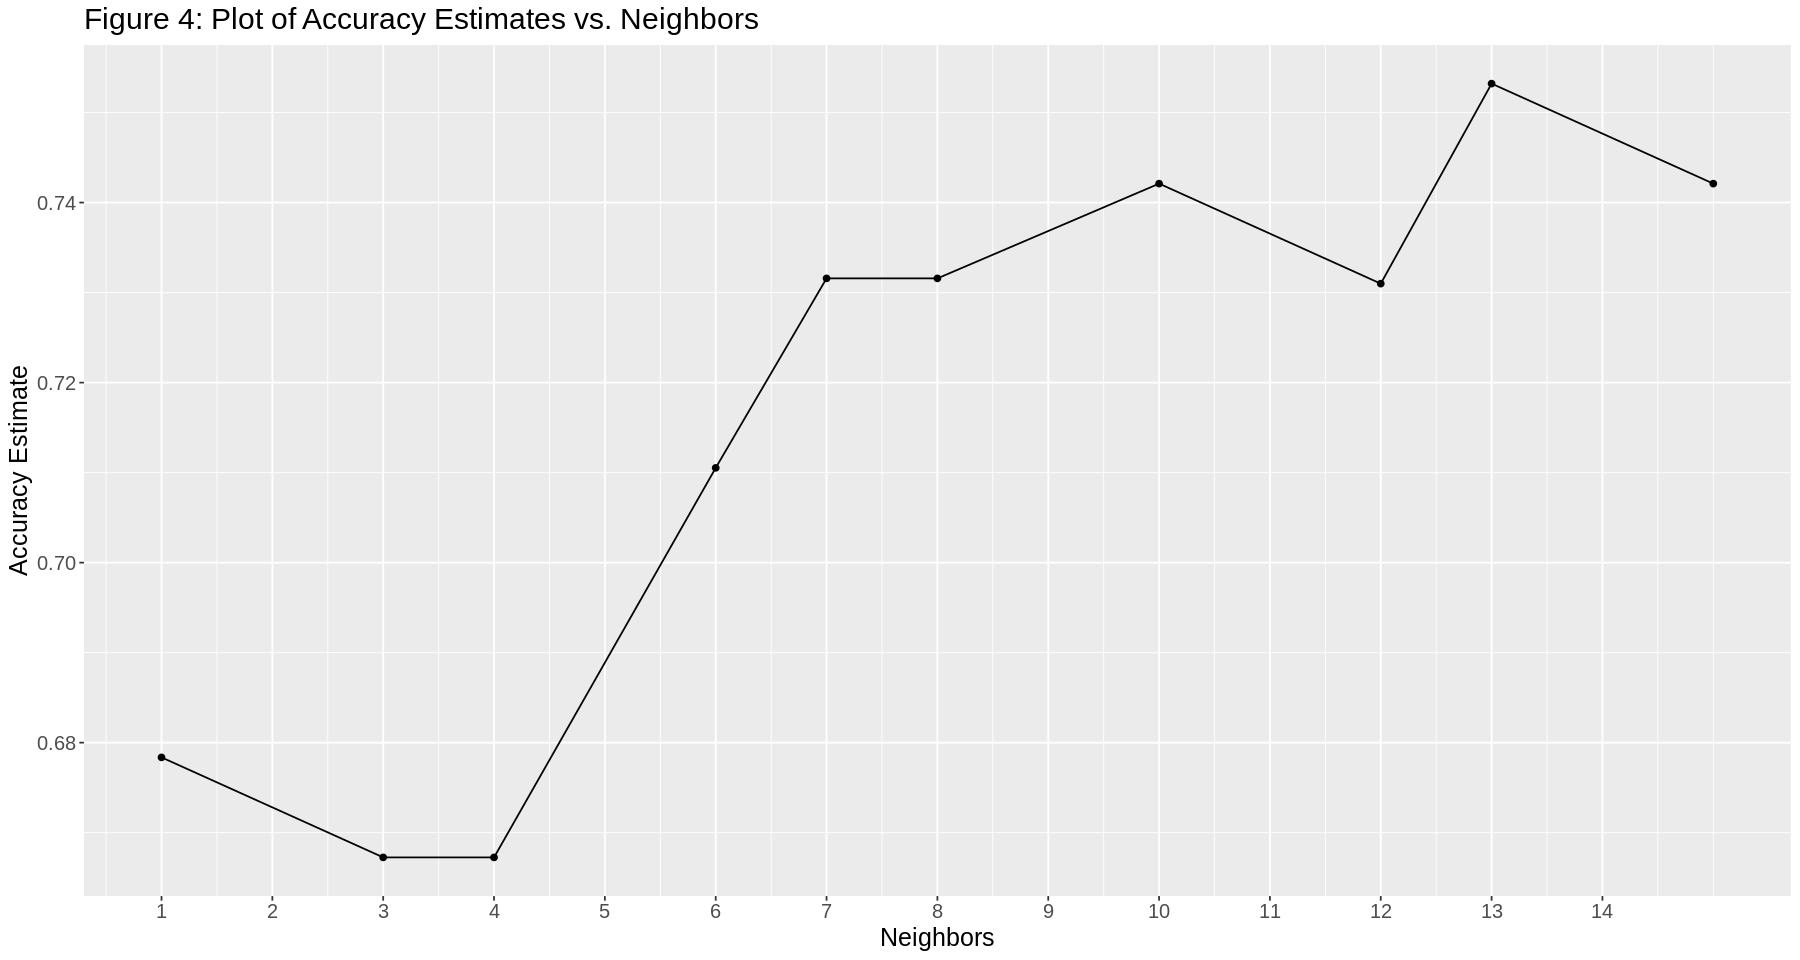

In [8]:
# Finding the best K

# update the recipe
bajaia_recipe <- recipe(Classes ~ Temperature + RH + Rain, data = bejaia_train) %>% 
                 step_center(all_predictors()) %>%
                 step_scale(all_predictors())

# set up the model
bejaia_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification") 

# perform 5-fold cross-validation 
bejaia_vfold <- vfold_cv(bejaia_train, v = 5, strata = Classes)

bejaia_workflow <- workflow() %>%
            add_recipe(bejaia_recipe) %>%
            add_model(bejaia_spec) %>%
            tune_grid(resamples = bejaia_vfold, grid = 10) %>%
            collect_metrics() 

# determine the accuracy of the classifier
bejaia_accuracy <- bejaia_workflow %>% 
                filter(.metric == "accuracy")

# plot Accuracy Estimates vs. Neighbours
options(repr.plot.width = 15, repr.plot.height = 8)

accuracy_plot <- bejaia_accuracy %>% 
                ggplot(aes(x = neighbors, y = mean)) + 
                geom_point() + 
                geom_line() + 
                ggtitle("Figure 4: Plot of Accuracy Estimates vs. Neighbors") +
                xlab("Neighbors") + 
                ylab("Accuracy Estimate") +
                scale_x_continuous(breaks = seq(0, 14, by = 1)) +  
                theme(text = element_text(size = 15))
accuracy_plot

From the graph, we observe that $K = 13$ will produce the best accuracy. We then build a new model specification with $13$ as the number of neighbours.

In [9]:
# set up model with the best number of neighbours
bejaia_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) %>%
                    set_engine("kknn") %>%
                    set_mode("classification")

bejaia_result <- workflow() %>%
                add_recipe(bejaia_recipe) %>%
                add_model(bejaia_spec_best) %>%
                fit(data = bejaia_train)

# perform prediction
bejaia_predict <- predict(bejaia_result, bejaia_test) %>%
                bind_cols(bejaia_test)

# determine the accuracy of the classifier
accuracies <- bejaia_predict %>%
            metrics(truth = Classes, estimate = .pred_class) %>%
            filter(.metric == "accuracy") %>%
            select(.estimate) %>%
            pull()

# confusion matrix
'Table 2: Confusion Matrix'
bejaia_conf <- bejaia_predict %>%
            conf_mat(truth = Classes, estimate = .pred_class)
bejaia_conf

# TODO: visualization of the analysis


[1] "Table 2: Confusion Matrix"

          Truth
Prediction fire not fire
  fire       11        5
  not fire    3       10

The confusion matrix shows us that $21$ observations were correctly labelled. However, $3$ observations were labelled as not fires when they were truly fires and $5$ observations were labelled as fires when they were in fact not fires. Our confusion matrix can also be visualized below as follows to have a better interpretation of our results.

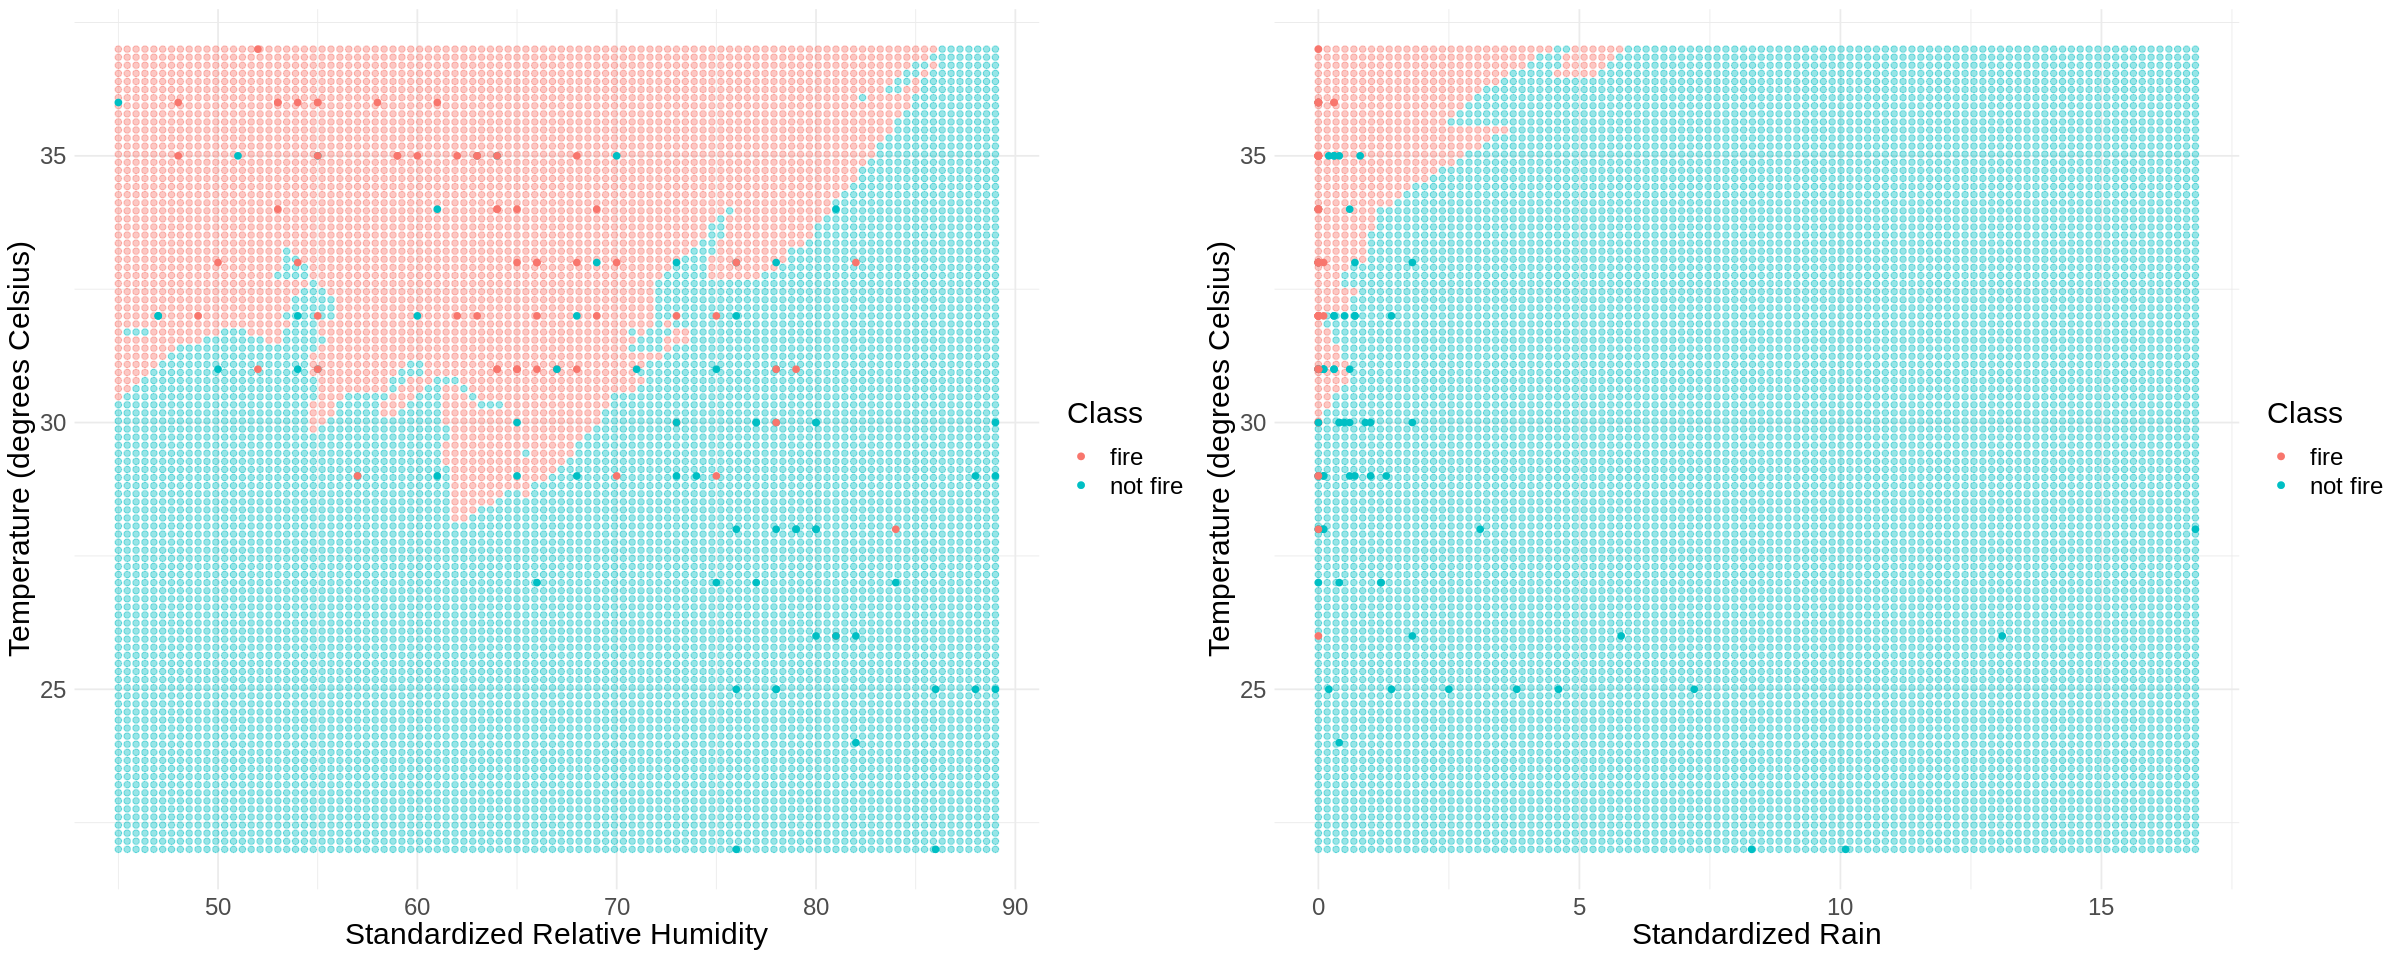

In [19]:
options(repr.plot.width = 20, repr.plot.height = 8)
# conf_plot <-  autoplot(bejaia_conf, type = "heatmap") +
#               scale_fill_gradient(low="#FBBFB2", high = "#F96E50") +
#               ggtitle("Figure 5: Visualization of the Confusion Matrix") +
#               theme(legend.position = "right") +
#               labs(fill="Frequency") +
#               theme(text=element_text(size=15))
# conf_plot

bejaia_recipe_2 <- recipe(Classes ~ Temperature + RH, data = bejaia_train) %>% 
                 step_center(all_predictors()) %>%
                 step_scale(all_predictors())

RH_seq <- seq(from = min(bejaia_fire_tidy$RH, na.rm = TRUE), 
             to = max(bejaia_fire_tidy$RH, na.rm = TRUE), 
             length.out = 100)
Temperature_seq <- seq(from = min(bejaia_fire_tidy$Temperature, na.rm = TRUE), 
             to = max(bejaia_fire_tidy$Temperature, na.rm = TRUE), 
             length.out = 100)

grid_points <- expand.grid(RH = RH_seq,
                           Temperature = Temperature_seq)

grid_predicted <- workflow() %>%
                add_recipe(bejaia_recipe_2) %>%
                add_model(bejaia_spec_best) %>%
                fit(data = bejaia_train) %>%
                predict(new_data = grid_points) %>%
                cbind(grid_points)

grid_humidity_plot <- grid_predicted %>%
    ggplot(aes(x = RH, 
               y = Temperature, 
               color = .pred_class)) + 
    geom_point(alpha=0.4) + 
    geom_point(data = bejaia_fire_tidy,
               aes(x = RH, 
                   y = Temperature, 
                   color = Classes)) + 
    theme_minimal() + 
    labs(y = "Temperature (degrees Celsius)", 
         x = "Standardized Relative Humidity",
         colour = "Class") +
    theme(text=element_text(size=18))

bejaia_recipe_3 <- recipe(Classes ~ Temperature + Rain, data = bejaia_train) %>% 
                 step_center(all_predictors()) %>%
                 step_scale(all_predictors())

Rain_seq <- seq(from = min(bejaia_fire_tidy$Rain, na.rm = TRUE), 
             to = max(bejaia_fire_tidy$Rain, na.rm = TRUE), 
             length.out = 100)
Temperature_seq <- seq(from = min(bejaia_fire_tidy$Temperature, na.rm = TRUE), 
             to = max(bejaia_fire_tidy$Temperature, na.rm = TRUE), 
             length.out = 100)

grid_points <- expand.grid(Rain = Rain_seq,
                           Temperature = Temperature_seq)

grid_predicted <- workflow() %>%
                add_recipe(bejaia_recipe_3) %>%
                add_model(bejaia_spec_best) %>%
                fit(data = bejaia_train) %>%
                predict(new_data = grid_points) %>%
                cbind(grid_points)

grid_rain_plot <- grid_predicted %>%
    ggplot(aes(x = Rain, 
               y = Temperature, 
               color = .pred_class)) + 
    geom_point(alpha=0.4) + 
    geom_point(data = bejaia_fire_tidy,
               aes(x = Rain, 
                   y = Temperature, 
                   color = Classes)) + 
    theme_minimal() + 
    labs(y = "Temperature (degrees Celsius)", 
         x = "Standardized Rain",
         colour = "Class") +
    theme(text=element_text(size=18))

plot_grid(grid_humidity_plot, grid_rain_plot)

# Discussion

## **NEW**
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?


We've found that our classifier gives has a 72.4% accuracy. Namely, our model correctly predicts whether a fire occurred on a specific date 72.4% of the time. Indeed, our classifier correctly predicted 11 observations as fires when they were truly fires and 10 observations as not fires when they were truly not fires.

**FROM PROPOSAL**

We expect to find that as temperature and wind speed increases and humidity and rain decreases, forest fires are more likely to occur.

The significance of deciding which factors are able to accurately predict when a forest fire is likely to occur is important in planning to mitigate the effects or preventing them altogether if we have sufficient warning. This way, inhabitants could take the necessary precautions to prevent fire propagation and preserve the environment and reduce air pollution. If a forest fire is predicted and easily detected, the fire can be more quickly extinguished. 

The results of our analysis lead to many unexplored questions. Future analyses could focus on which specific weather conditions have the most significant impact on determining the occurrence of forest fires. 


---

# References

AINI, A., CURT, T., & BEKDOUCHE, F. (2019). Modelling fire hazard in the southern mediterranean fire rim (bejaia region, northern algeria). Environmental Monitoring and Assessment, 191(12), 1-19. https://doi.org/10.1007/s10661-019-7931-0

Curt, T., Aini, A., & Dupire, S. (2020). Fire activity in mediterranean forests (the algerian case). Fire (Basel, Switzerland), 3(58), 58. https://doi.org/10.3390/fire3040058